# ML_HW6 
* implement k-means clustering, kernel k-means, spectral clustering, DBSCAN

In [165]:
import numpy as np
from matplotlib import pyplot as plt
import random

## load data

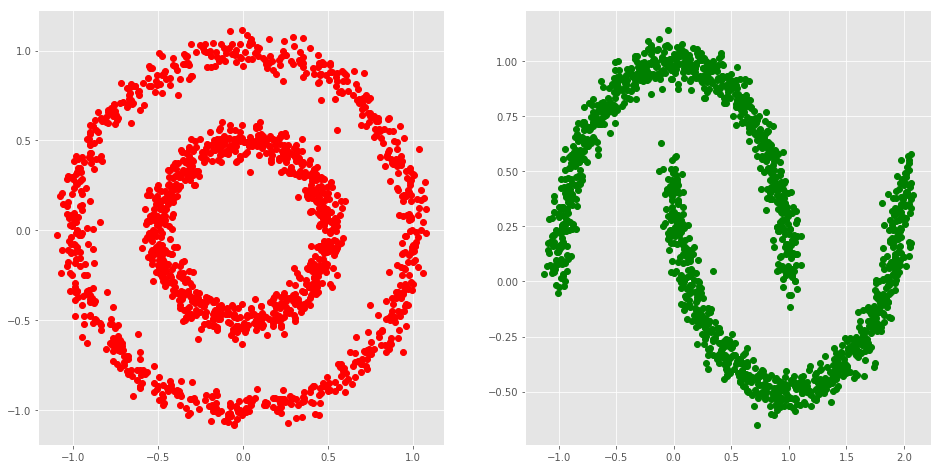

In [166]:
circle = np.loadtxt('circle.txt', delimiter=',')
moon = np.loadtxt('moon.txt', delimiter=',')
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(circle[:, 0], circle[:, 1], 'or')
plt.subplot(122)
plt.plot(moon[:, 0], moon[:, 1], 'og')
plt.show()

In [219]:
def L2(vector1, vector2):  
    return np.sqrt(np.sum((vector2 - vector1)**2))

def initCentroids(D, k, init='random'):  
    numSamples, dim = D.shape  
    centroids = np.zeros((k, dim))
    if init == 'random':
        for i in range(k):  
            index = np.random.randint(0, numSamples)
            centroids[i, :] = D[index, :]
        
    else: #'kmeans++'
        first = np.random.randint(0, numSamples)
        centroids[0] = np.copy(D[first])
        d = [0.0 for _ in range(numSamples)]
        for i in range(1, k):
            sum_all = 0
            for j in range(numSamples):
                d[j] = nearest(D[j, ], centroids[0:i])
                sum_all += d[j]
            sum_all *= random.random()
            for j, di in enumerate(d):
                sum_all -= di
                if sum_all > 0:
                    continue
                centroids[i] = np.copy(D[j])
                break
    return centroids
    
def nearest(point, centroids):
    min_dist = float("inf")
    m = centroids.shape[0]
    for i in range(m):
        d = L2(point, centroids[i])
        if min_dist > d:
            min_dist = d
    return min_dist



def showCluster(D, labels, r, centroids=None, evtdata=None, clusterType='kmeans'):  
    numSamples, dim = D.shape    
    mark = ['or', 'ob', 'og', 'oc', 'om', 'oy', '*k']  
    plt.figure()
    for i in range(numSamples):  
        markIndex = int(labels[i])  
        plt.plot(D[i, 0], D[i, 1], mark[markIndex]) 
    try:
        for i in range(centroids.shape[0]):  
            plt.plot(centroids[i, 0], centroids[i, 1], mark[-1], markersize = 12)
    except:
        pass
    plt.figure()
    for i in range(numSamples):  
        
        markIndex = int(labels[i])  
        try:
            plt.plot(evtdata[i, 0]*10**3, evtdata[i, 1]*10**3, mark[markIndex])  
        except:
            pass
    plt.savefig("results/"+clusterType+str(r))
    plt.show()

## 1. k-means clustering

In [168]:
def kmeans(D, k):  
    r = 0
    numSamples = D.shape[0]  
    clusterAssment = np.zeros((numSamples, 2))
    clusterChanged = True
    centroids = initCentroids(D, k)  
    while clusterChanged:
        clusterChanged = False
        #Assign
        for i in range(numSamples):  
            minDist  = float("inf")
            minIndex = 0  
            for j in range(k):  
                distance = L2(centroids[j, :], D[i, :])  
                if distance < minDist:  
                    minDist  = distance  
                    minIndex = j  
            if clusterAssment[i, 0] != minIndex:  
                clusterChanged = True  
                clusterAssment[i, :] = minIndex, minDist**2 
        #update
        for j in range(k):  
            pointsInCluster = D[np.nonzero(clusterAssment[:, 0] == j)[0]]  
            centroids[j, :] = np.mean(pointsInCluster, axis = 0)  
        r+=1
        showCluster(D, clusterAssment[:, 0], r, centroids=centroids, clusterType='kmean')

In [ ]:
k = 4
# kmeans(circle , k)
print("="*60)
kmeans(moon , k)

## 2. kernel k-means

In [199]:
#算出RBF kernel的gram matrix
def rbfMatrix(D,sigma):
    n = D.shape[0]
    M = np.identity(n)
    gamma = 1 / (2*sigma**2)
    for i in range(n):
        for j in range(n):
            if i > j:
                M[i, j] = np.exp(-gamma * L2(D[i,:], D[j,:]))
                M[j, i] = M[i, j]
    return M

def kernelDist(j, k, alpha, rbfm):
    n = sum(alpha[k])
    rbfm[j, j] -= 2 * alpha[k].dot(rbfm[j].T) / n
    rbfm[j, j] += alpha[k].dot(rbfm).dot(alpha[k].T) / n**2
    return rbfm[j,j]

def kerkmeans(D, k): 
    r = 0
    numSamples = D.shape[0]   
    clusterAssment = np.zeros((numSamples, 2))
    centroids = initCentroids(D, k)
    alpha = np.zeros((k, numSamples))
    #Assign and find alpha
    for i in range(numSamples):  
        minDist  = float("inf")
        minIndex = 0  
        for j in range(k):  
            distance = L2(centroids[j, :], D[i, :])  
            if distance < minDist:  
                minDist  = distance  
                minIndex = j
        alpha[minIndex,i]=1
        clusterAssment[i, :] = minIndex, minDist**2
    
    #update
    for j in range(k):
        pointsInCluster = D[np.where(clusterAssment[:, 0] == j)[0]]
        centroids[j, :] = np.mean(pointsInCluster, axis = 0)
    showCluster(D, clusterAssment[:, 0], r, centroids=centroids, clusterType='kernelKmeans')
    r+=1
    
    rbf = rbfMatrix(D, 1)
    clusterChanged = True
    dist = np.zeros((numSamples, k))
    while clusterChanged:
        clusterChanged = False
        dist.fill(0)
        
        #assign
        for kk in range(k):
            n = sum(alpha[kk])
            dist[:, kk] = np.diag(rbf)
            dist[:, kk] -= 2 * alpha[kk].dot(rbf.T) / n
            dist[:, kk] += np.tile(alpha[kk].dot(rbf).dot(alpha[kk].T),numSamples) / n**2
        for kk in range(k):
            if np.count_nonzero(clusterAssment[:, 0] != np.argmin(dist, axis=1)) != 0:
                clusterChanged = True
            alpha[kk, np.where(clusterAssment[:, 0] != np.argmin(dist, axis=1))] = 0
            alpha[kk, np.where(clusterAssment[:, 0] == np.argmin(dist, axis=1))] = 1
        
        #update
        for j in range(k):
            pointsInCluster = D[np.where(clusterAssment[:, 0] == j)[0]]
            centroids[j, :] = np.mean(pointsInCluster, axis = 0)
        r+=1
        showCluster(D, clusterAssment[:, 0], r, centroids=centroids, clusterType='kernelKmeans')


KeyboardInterrupt: 

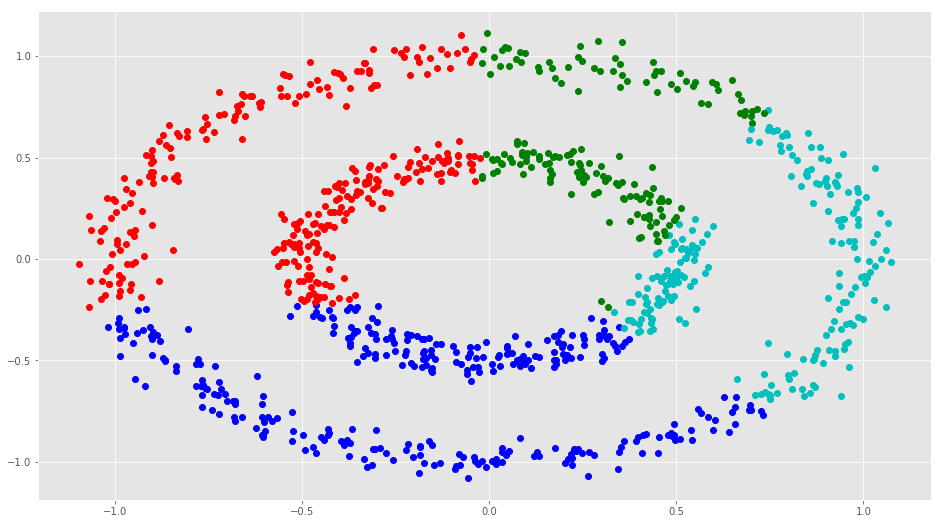

In [200]:
k=4
# print("circle")
kerkmeans(circle,k)
print("moon")
# kerkmeans(moon,k)

## 3. spectral clustering

In [220]:
def Spectralkmeans(D,k):
    r = 0
    L = Laplacian(D,1)
    evtdata = kEigenvector(L,k)
    numSamples = evtdata.shape[0]  
    clusterAssment = np.zeros((numSamples, 2))
    clusterChanged = True  
    centroids = initCentroids(evtdata, k)  

    while clusterChanged:
        clusterChanged = False
        #assign
        for i in range(numSamples):  
            minDist  = float("inf")
            minIndex = 0  
            for j in range(k):  
                distance = L2(centroids[j, :], evtdata[i, :])  
                if distance < minDist:  
                    minDist  = distance  
                    minIndex = j
            if clusterAssment[i, 0] != minIndex:  
                clusterChanged = True  
                clusterAssment[i, :] = minIndex, minDist**2 
        #update
        for j in range(k):  
            pointsInCluster = evtdata[np.nonzero(clusterAssment[:, 0] == j)[0]]  
            centroids[j, :] = np.mean(pointsInCluster, axis = 0) 
            
        showCluster(D, clusterAssment[:, 0], r, evtdata=evtdata, centroids=centroids, clusterType='spectral')
        r += 1


def Laplacian(dataSet, sigma): # L = D - W
    W = rbfMatrix(dataSet,sigma)
    n = len(W)
    D = np.zeros([n,n])
    for i in range(n):
        D[i,i] = sum(W[i])
    return D-W


def kEigenvector(L,k):
    eigvalue, eigvector = np.linalg.eig(L)
    n = len(eigvalue)
    dictev = dict(zip(eigvalue, range(0,n)))
    keig = np.sort(eigvalue)[0:k]
    ix = [dictev[i] for i in keig]
    evtdata = eigvector[:,ix]
    return evtdata

k=2
circle
moon


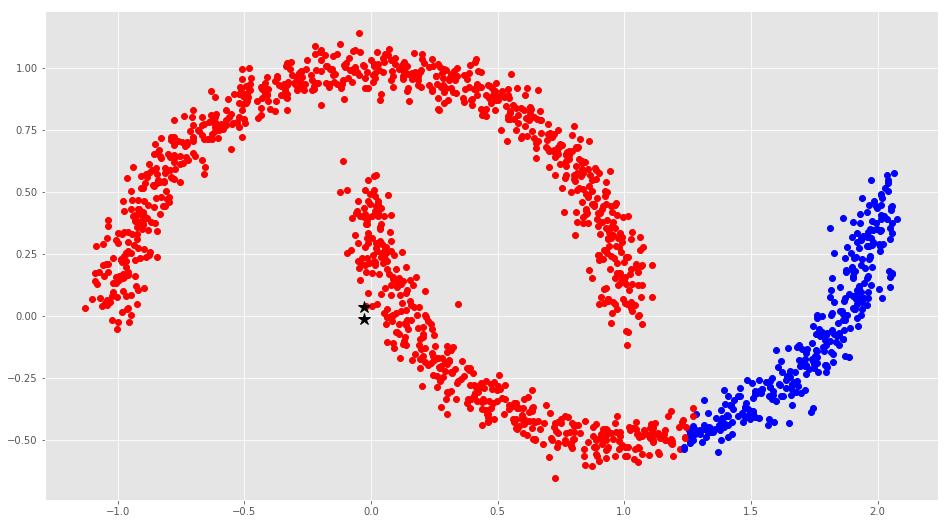

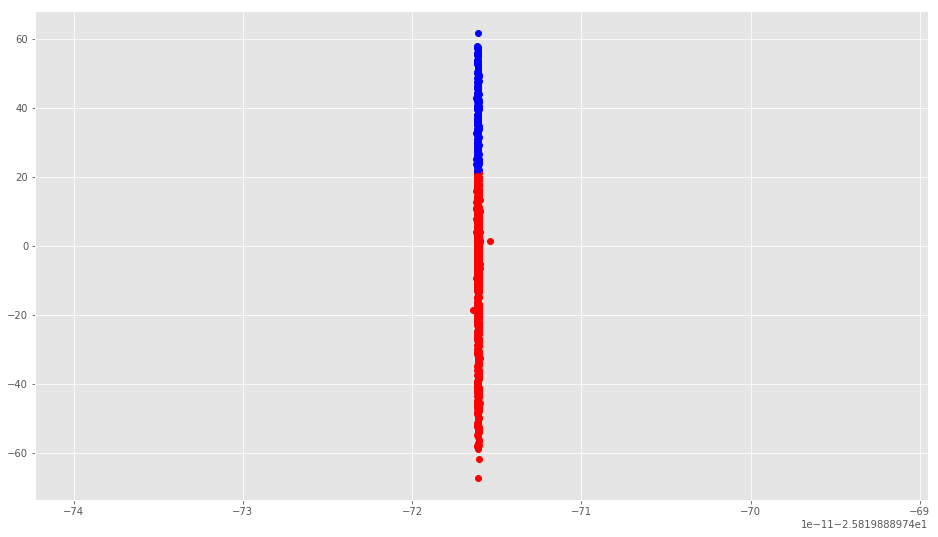

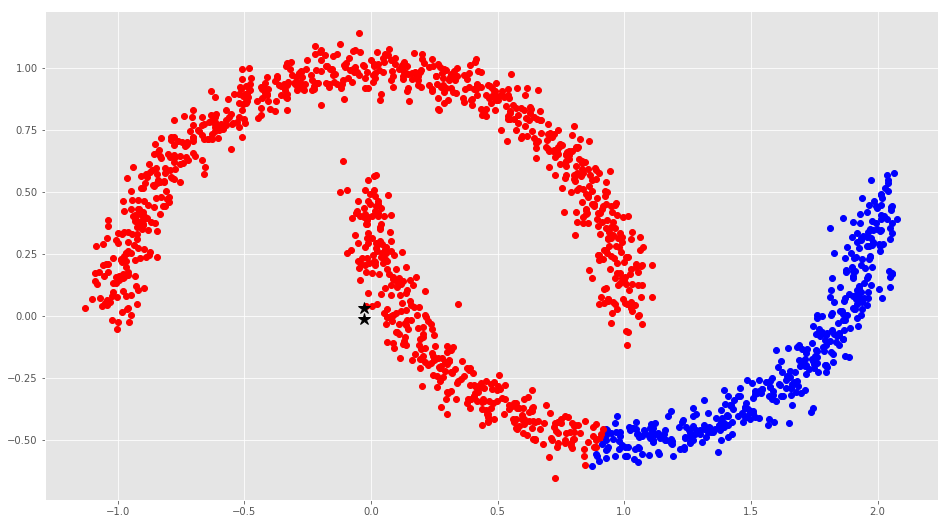

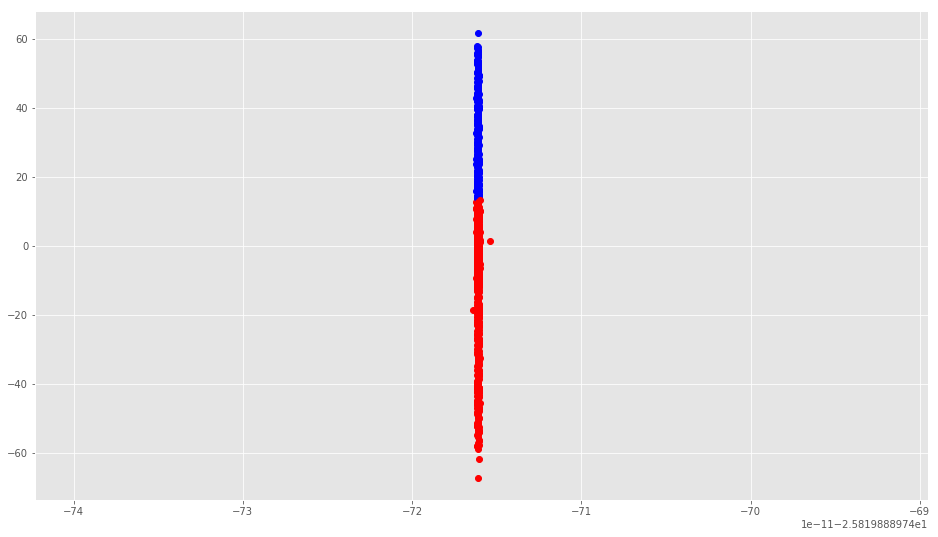

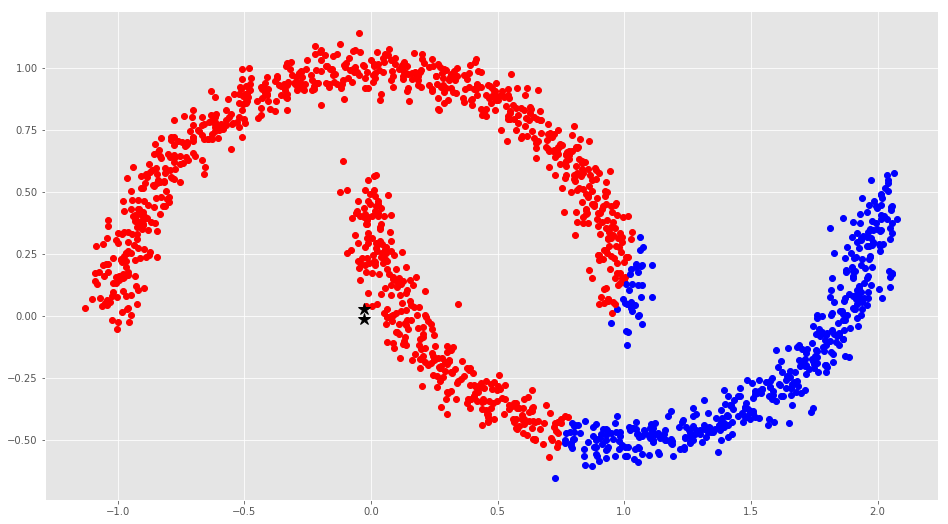

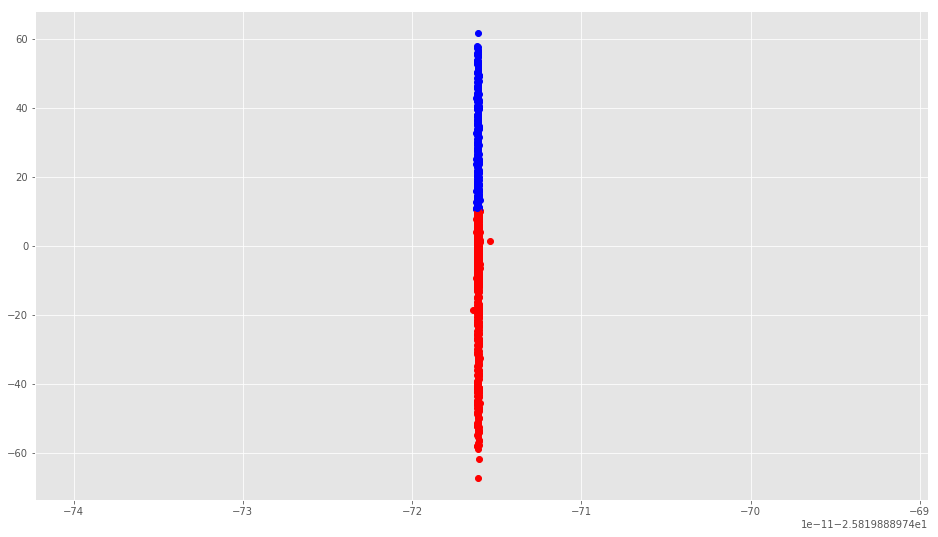

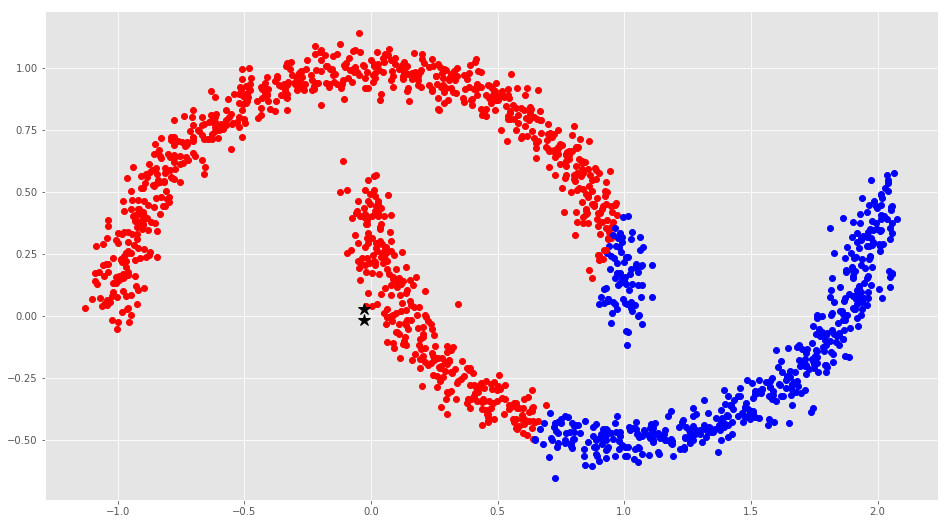

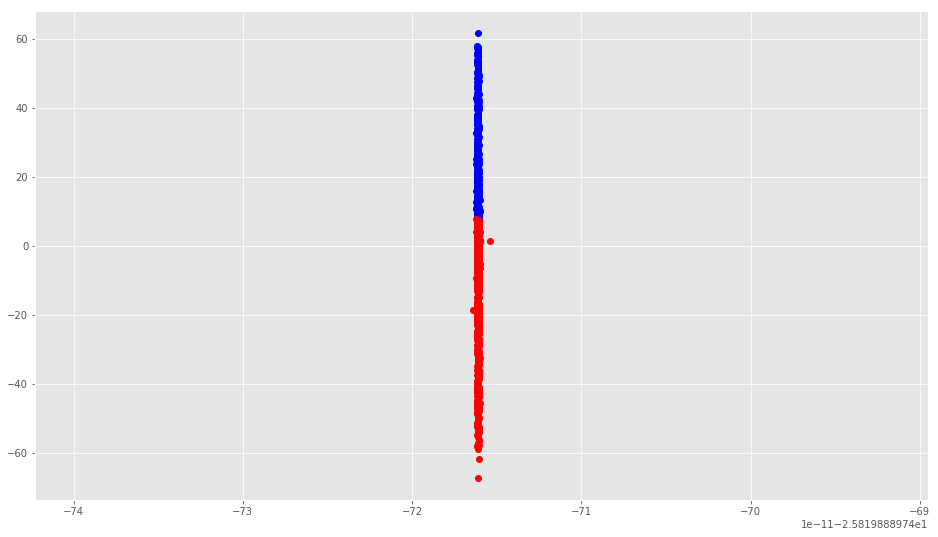

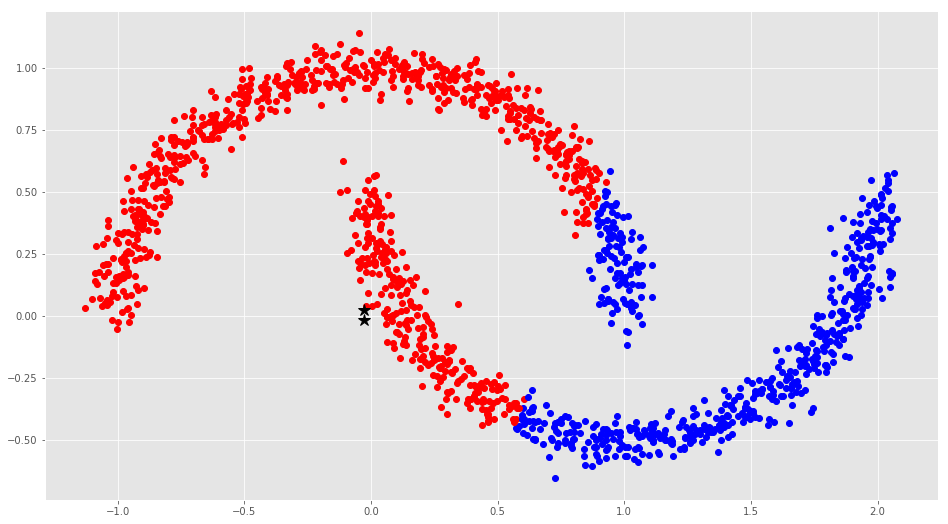

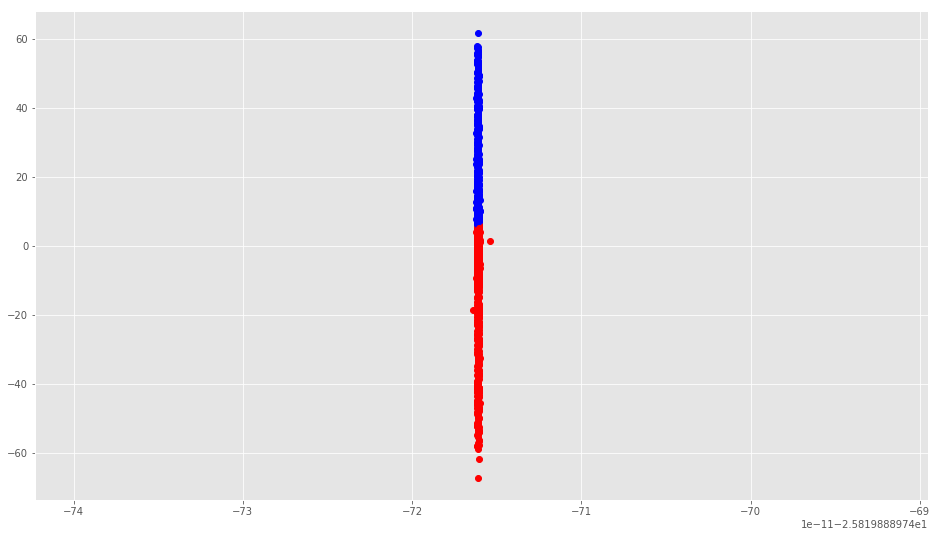

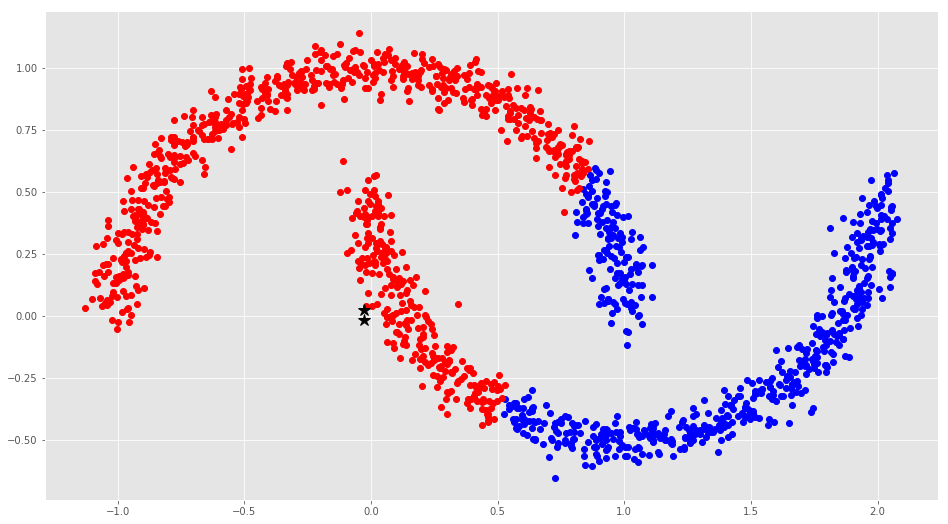

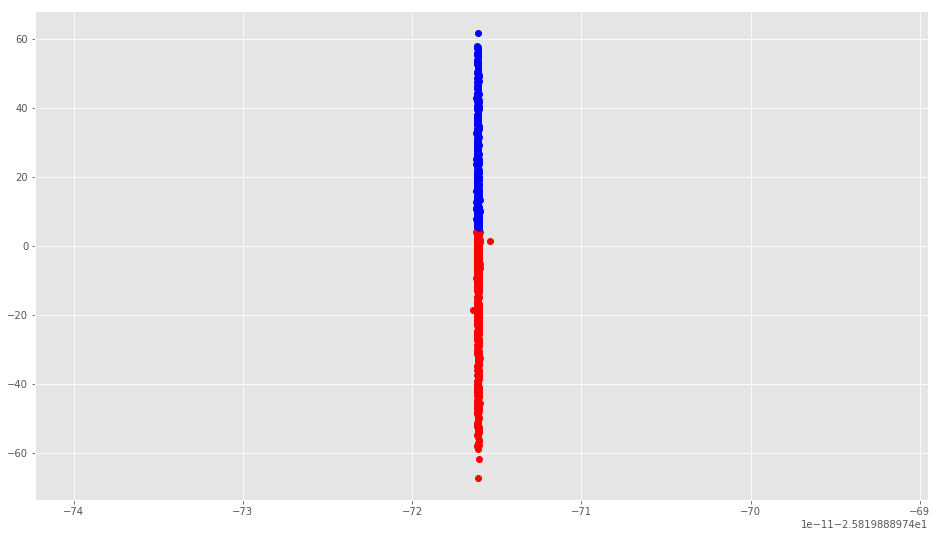

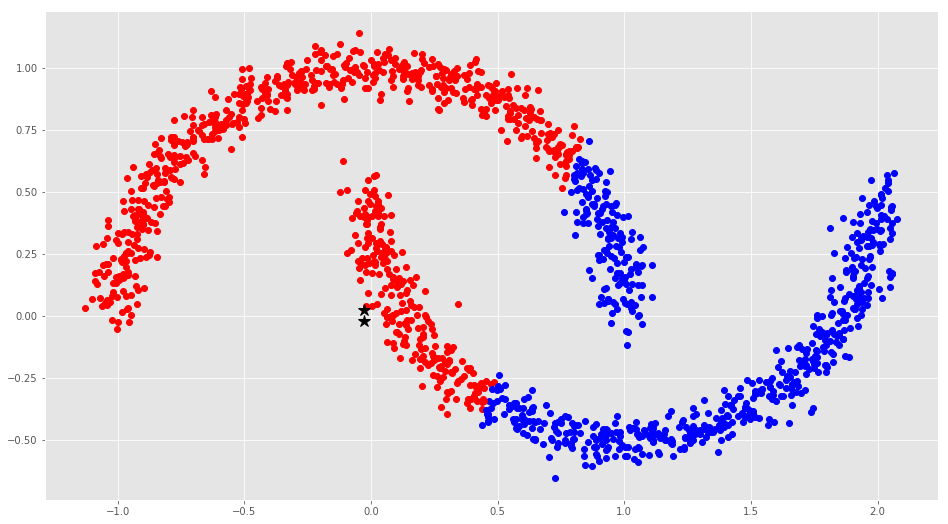

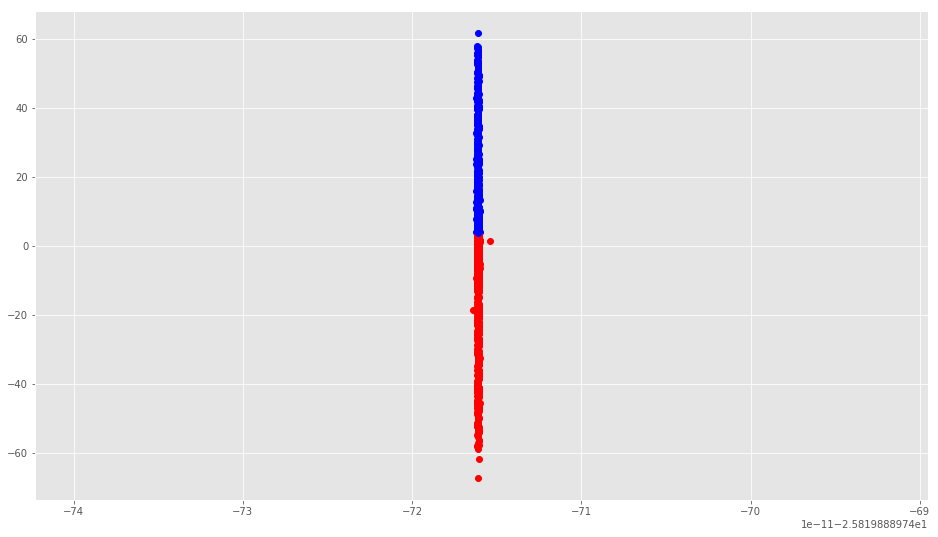

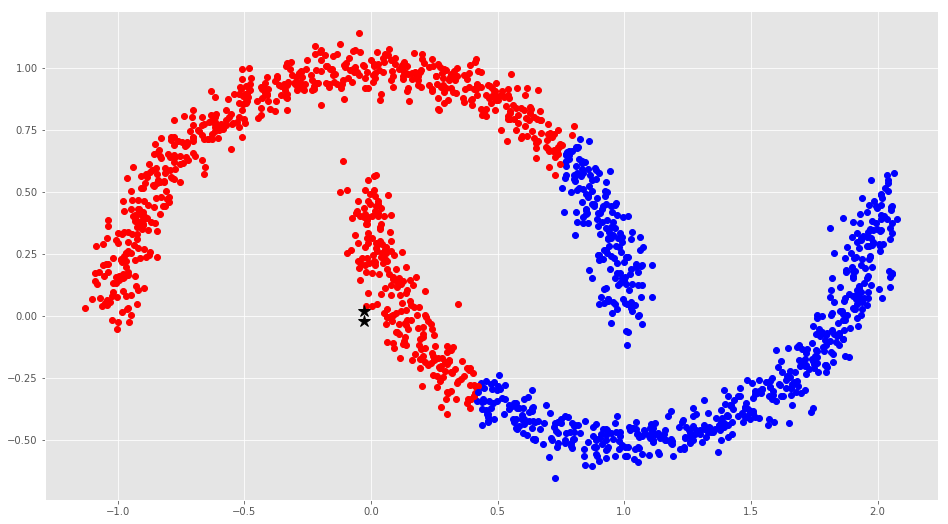

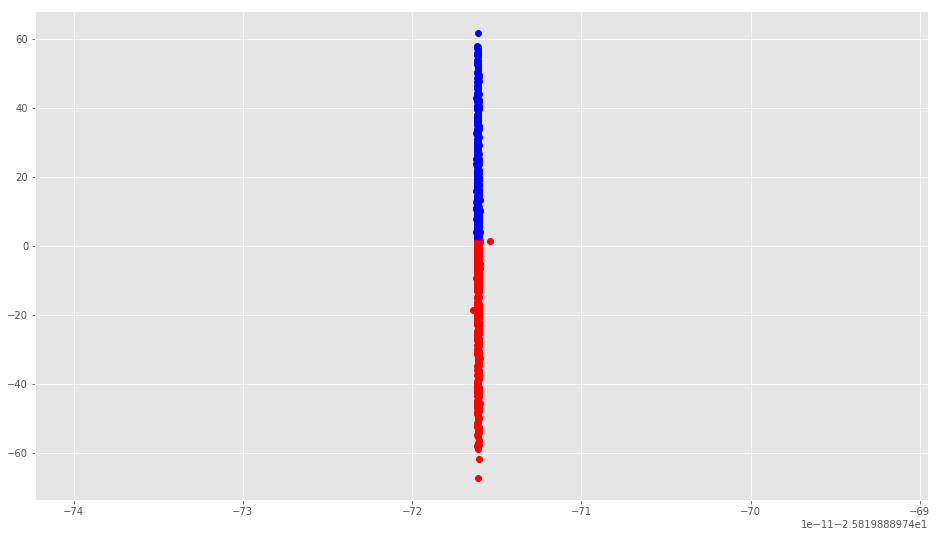

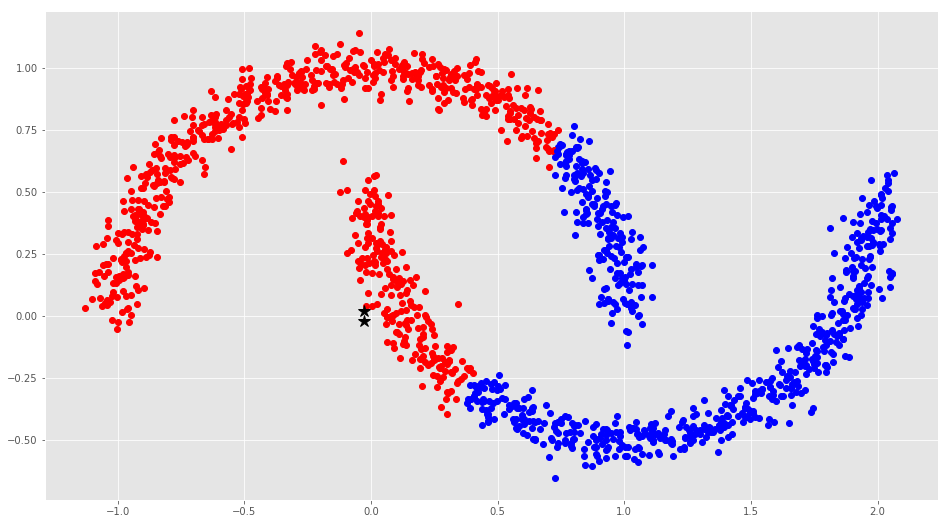

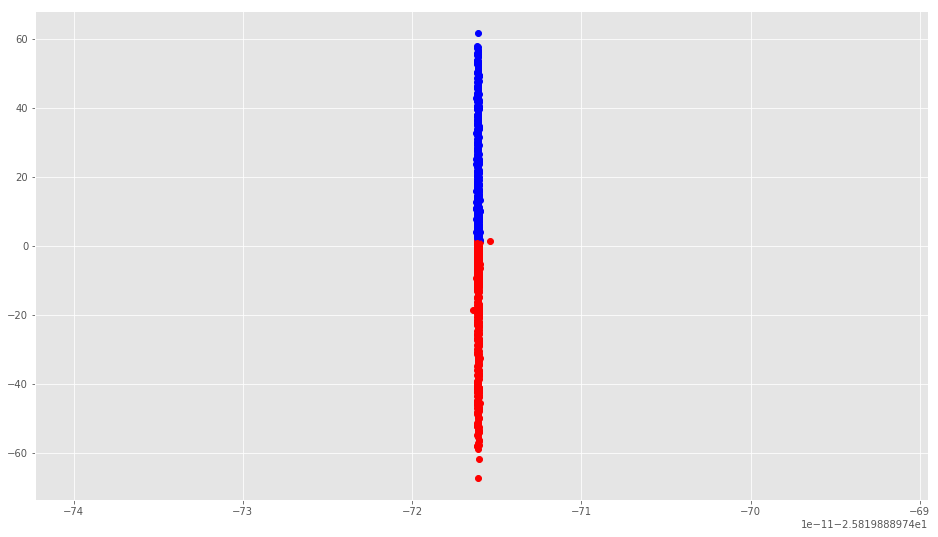

KeyboardInterrupt: 

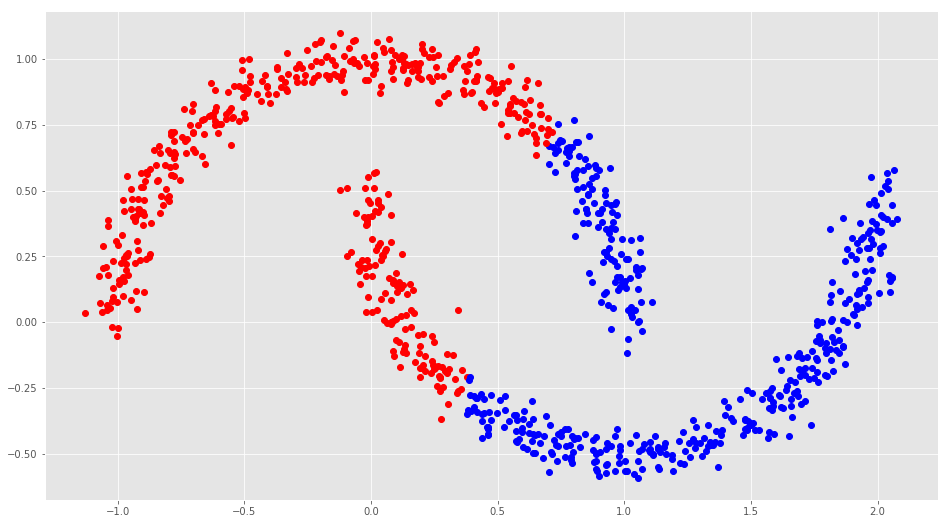

In [222]:
k=2
print("k=2")
print("circle")
# Spectralkmeans(circle,k)
print("moon")
Spectralkmeans(moon,k)

## 4. DBSCAN

In [185]:
def DBSCAN(D, epsilon, MinPts):
    labels = [0]*len(D)
    C = 0
    for P in range(len(D)):
        if not (labels[P] == 0):
            continue
        NeighborPts = regionQuery(D, P, epsilon)
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        else: 
            C += 1
            labels = growCluster(D, labels, P, NeighborPts, C, epsilon, MinPts)
        showCluster(D, labels, C, clusterType='DBSCAN')


def growCluster(D, labels, P, NeighborPts, C, epsilon, MinPts):
    labels[P] = C
    i = 0
    while i < len(NeighborPts):    
        Pn = NeighborPts[i]
        if labels[Pn] == -1:
            labels[Pn] = C
        elif labels[Pn] == 0:
            labels[Pn] = C
            PnNeighborPts = regionQuery(D, Pn, epsilon)
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
        i += 1
    return labels


def regionQuery(D, P, epsilon):
    neighbors = []
    for Pn in range(0, len(D)):
        if np.linalg.norm(D[P] - D[Pn]) < epsilon:
            neighbors.append(Pn)
    return neighbors



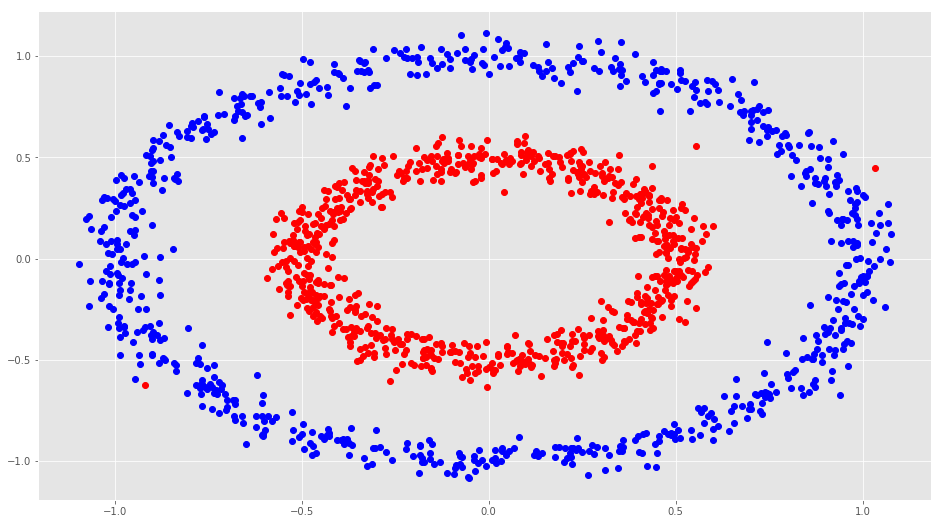

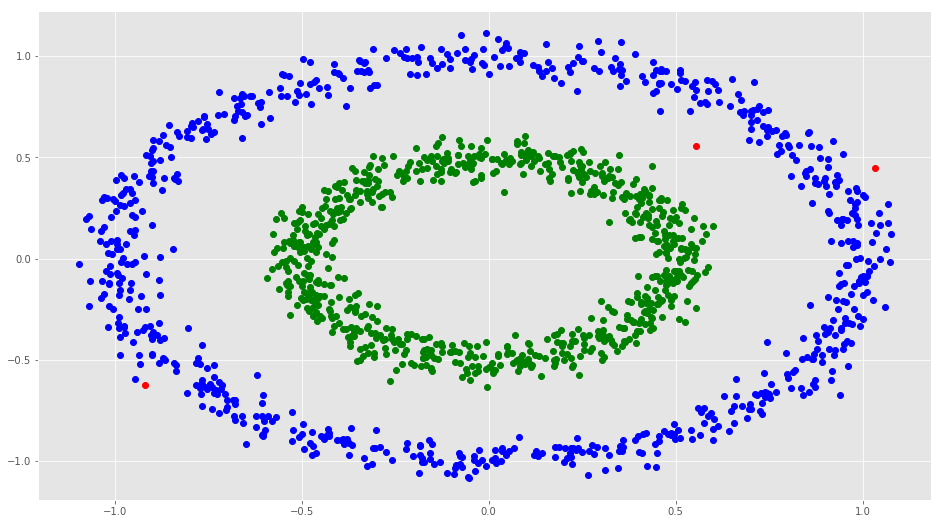

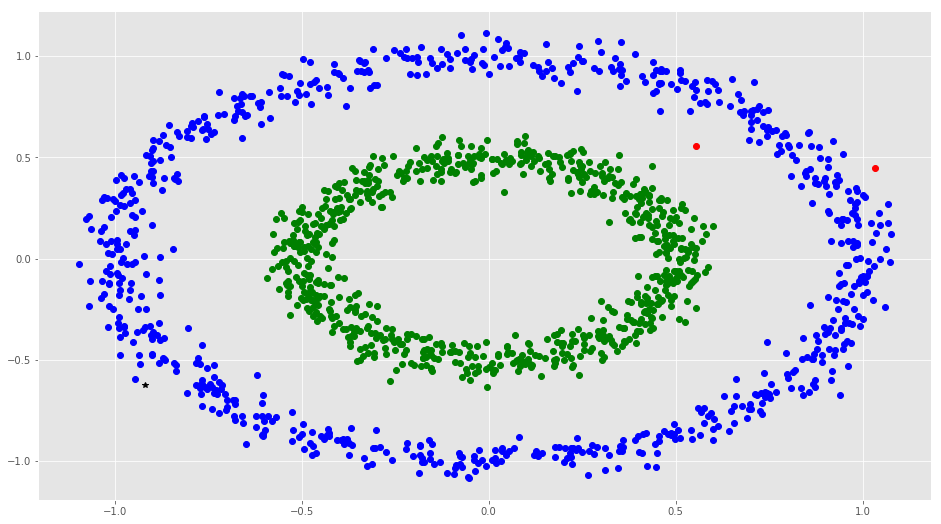

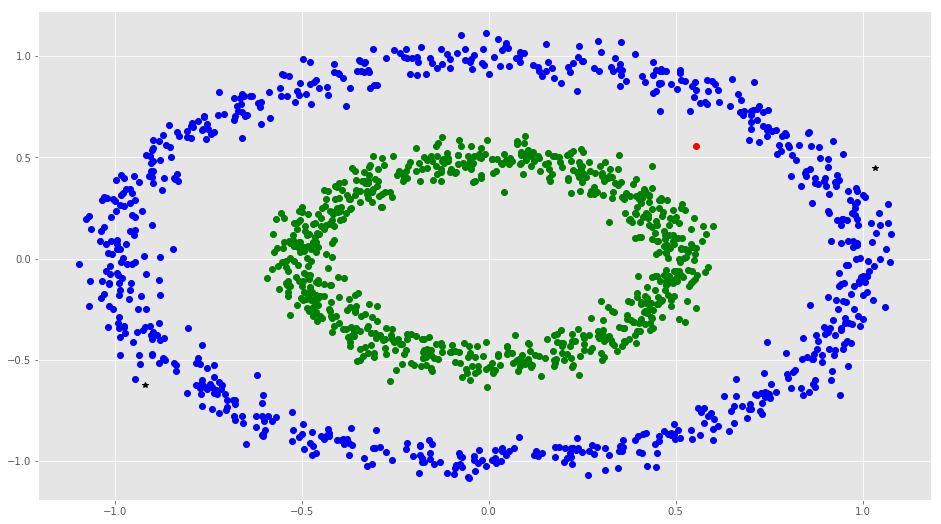

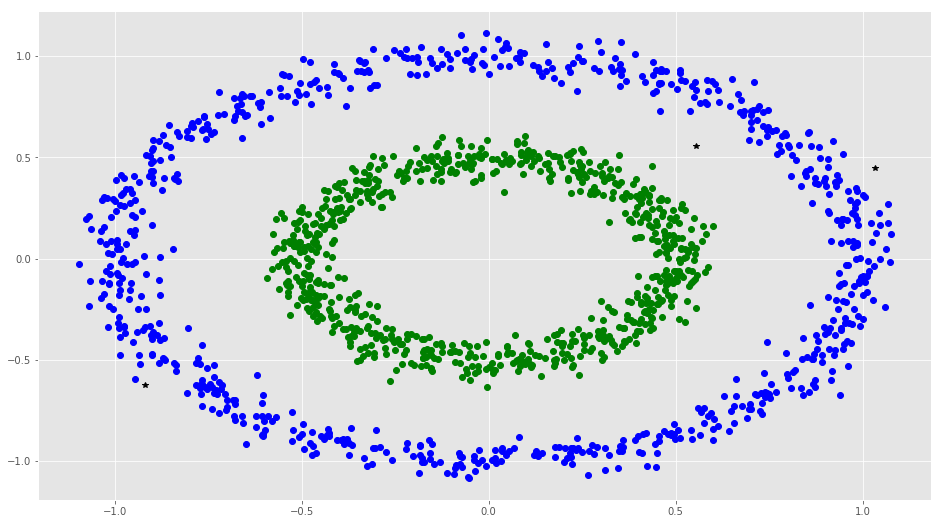

In [189]:
DBSCAN(circle, 0.1, 5)